<a href="https://colab.research.google.com/github/shriver42/ESAA/blob/%ED%95%84%EC%82%AC-%EA%B3%BC%EC%A0%9C/YB_%EC%BB%A4%EB%A6%AC%ED%81%98%EB%9F%BC_%EB%B3%B5%EC%8A%B5_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YB 커리큘럼 복습 9~16주차

### 1. 분류 실습 - 캐글 신용카드 사기 검출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
pip install imbalanced-learn

In [3]:
card_df = pd.read_csv('/content/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
from sklearn.model_selection import train_test_split

#인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

In [5]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]
  # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
  X_train, X_test, y_train, y_test = \
  train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [6]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는지 살펴봄

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)

    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [8]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

#3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   60    88]]
정확도: 0.9992, 정밀도: 0.8800, 재현율: 0.5946,    F1: 0.7097, AUC:0.9593


In [9]:
#인자로 사이킷런 Estimator 객체와 학습/테스트 데이터 세트를 입력 ㅂㄷ다아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None,tgt_test=None):
  model.fit(ftr_train,tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:, 1]
  get_clf_eval(tgt_test,pred,pred_proba)

In [10]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves=64,n_jobs=-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

데이터 분포도 변환 후 모델 학습/예측/평가

- 왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 테스트

<Axes: xlabel='Amount', ylabel='Density'>

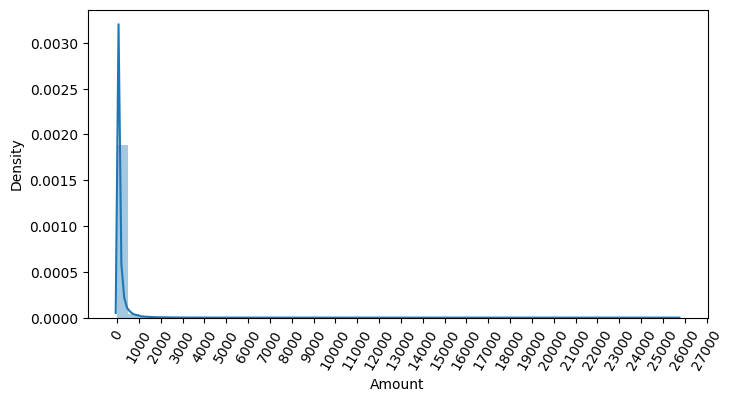

In [11]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

In [12]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [13]:
#Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('###로지스틱 회귀 예측 성능###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train,ftr_test = X_test, tgt_train=y_train, tgt_test = y_test)

print('###LightGBM 예측 성능###')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves=64, n_jobs =-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test =X_test, tgt_train=y_train, tgt_test = y_test)

###로지스틱 회귀 예측 성능###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
###LightGBM 예측 성능###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

로그 변환 : 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법, 원래 값을 log 값으로 면환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해 줌

In [14]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  #넘파이의 log1p()를 이용해 Amount 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  return df_copy

Amount 피처를 로그 변환한 후 다시 로지스틱 회귀와 LightGBM 모델을 적용한 후 예측 성능을 확인

In [15]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('###로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('###LightGBM 예측 성능')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test,tgt_train=y_train, tgt_test=y_test)

###로지스틱 회귀 예측 성능###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
###LightGBM 예측 성능
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

이상치 데이터 제거 후 모델 학습/예측/평가

- 이상치 데이터 : 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터, 아웃라이어

- 사분위 : 전체 데이터를 값이 높은 순으로 정렬하고, 이를 1/4씩으로 구간을 분할하는 것을 지칭

- IQR : Q1~Q3 -> 시각화 -> 박스 플롯

- 이상치 데이터를 IQR을 이용해 제거

<Axes: >

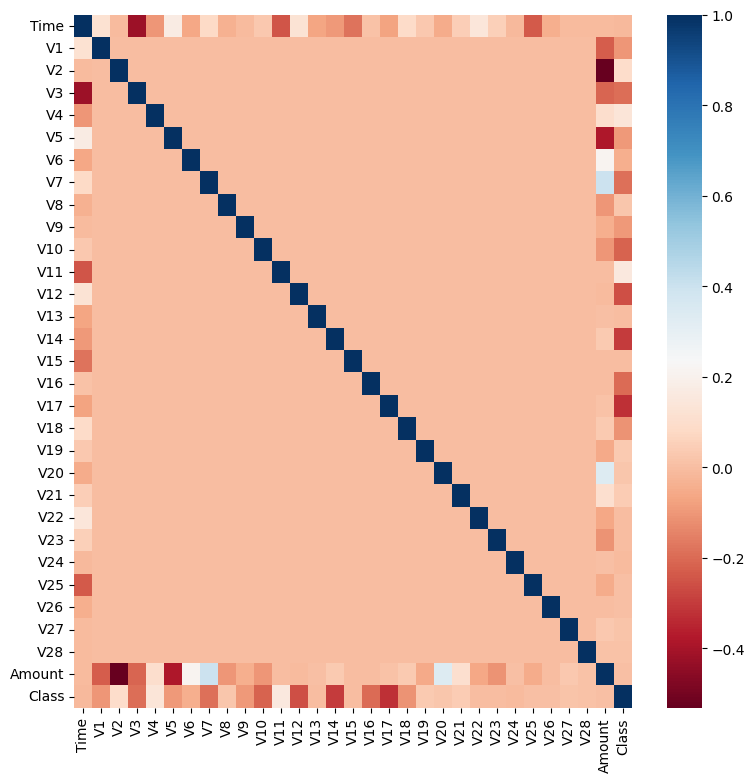

In [16]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

양의 상관관계가 높을수록 색깔이 진한 파란색, 음의 상관관계가 높을수록 색깔이 진한 빨간색

In [17]:
import numpy as np

def get_outlier(df = None, column = None, weight = 1.5):
  #fraud에 해당하는 column 데이터만 추출, 1/4분위와  3/4 분위 지점을 np.percentile로 구함
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  #IQR를 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr*weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  #최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 데이터 프레임 인덱스 반환
  outlier_index = fraud[(fraud < lowest_val)|(fraud > highest_val)].index
  return outlier_index

In [18]:
outlier_index = get_outlier(df = card_df, column = 'V14', weight = 1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [19]:
#get_preprocessed_df()를 로그 변환 후 V14의 피처 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df = None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
  #이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df = card_df, column = 'V14', weight = 1.5)
  df_copy.drop(outlier_index, axis = 0, inplace = True)
  #행을 제거해야하니까 axis = 0으로 지정
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [20]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape,y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


In [21]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


분류 결정 임곗값에 따른 정밀도와 재현율 곡선을 통해 SMOTE로 학습된 로지스틱 회귀 모델에 어떠한 문제가 발생하고 있는지 시각적으로 확인

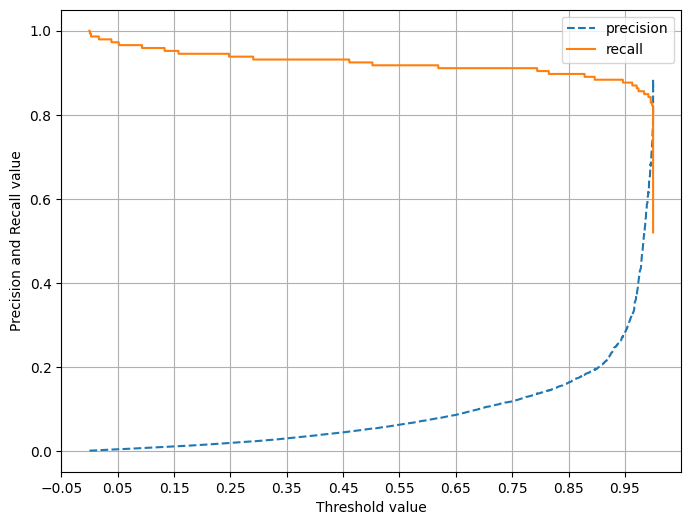

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

    #x축을 threshold값으로, y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    #threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    #x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

In [23]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over,tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

### 2. 회귀 실습 - 자전거 대여 수요 예측

데이터 클렌징 및 가공

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
bike_df = pd.read_csv('/content/train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [26]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [27]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [28]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace =True)

In [29]:
# 사이킷런은 RMSLE를 제공하지 않으므로 평가함수 만듦
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))


따라서 log()보다는 log1p 이용 : log 변환값에 1을 더함

- 로그 변환, 피처 인코딩과 모델 학습/예측/평가

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis = 1,inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                    test_size = 0.3, random_state = 0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
evaluate_regr(y_test,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [31]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측값을 서로 비교 할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns = ['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

    # 예측값과 실제값이 가장 큰 데이터 순으로 출력.
    print(result_df.sort_values('diff', ascending = False)[:n_tops])

get_top_error_data(y_test, pred, n_tops = 5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

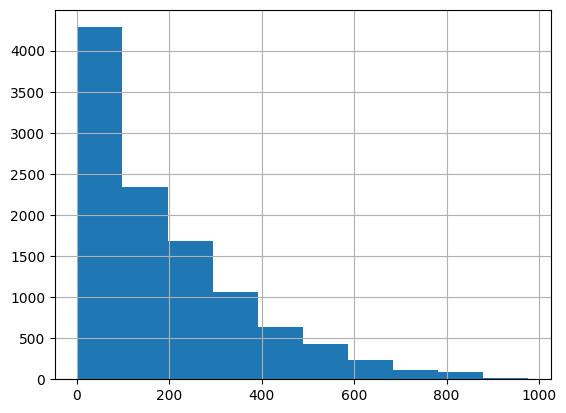

In [32]:
y_target.hist()

<Axes: >

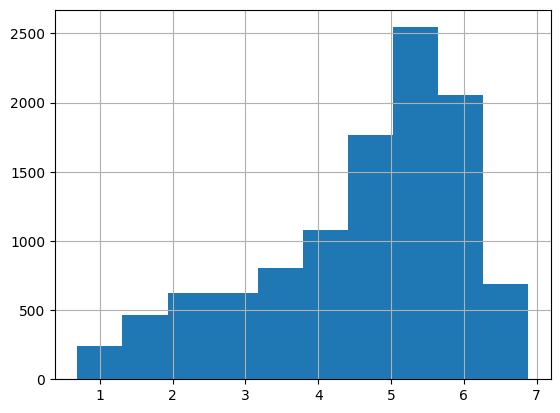

In [33]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [34]:
# 타깃 칼럼인 count값을 로그변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log,
                                                   test_size = 0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 target값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 에측했으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<Axes: ylabel='None'>

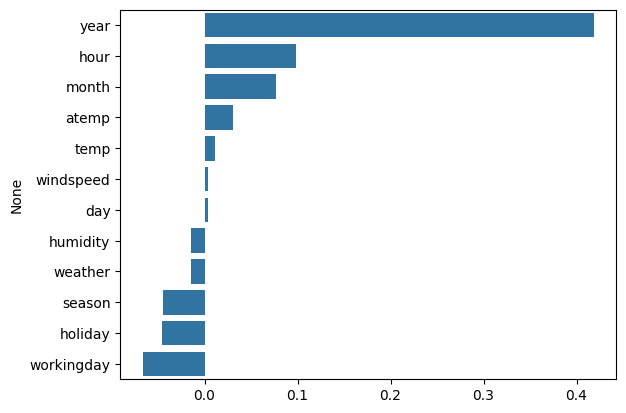

In [35]:
coef = pd.Series(lr_reg.coef_, index= X_features.columns)
coef_sort = coef.sort_values(ascending = False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [36]:
# year, month, day, hour를 one hot encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day',
                                                    'hour', 'holiday', 'workingday',
                                                    'season', 'weather'])

In [37]:
# 원핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                   test_size = 0.3, random_state=0)
# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False) :
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('####', model.__class__.__name__, '####')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

# 모델별 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha = 0.01)

for model in [lr_reg, ridge_reg, lasso_reg] :
    get_model_predict(model , X_train, X_test, y_train, y_test, is_expm1=True)

#### LinearRegression ####
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
#### Ridge ####
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
#### Lasso ####
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<Axes: ylabel='None'>

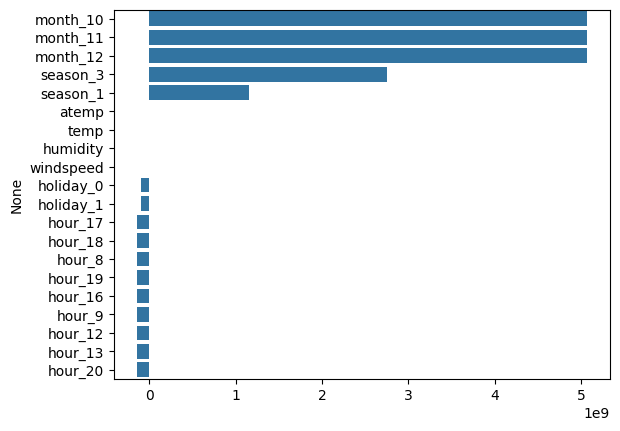

In [38]:
coef = pd.Series(lr_reg.coef_, index = X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [39]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트 , GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators = 500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg] :
    # xgboost의 경우 df이 입력될 경우 오류 발생 가능. ndarray로 변환
    get_model_predict(model, X_train.values, X_test.values, y_train.values,
                     y_test.values, is_expm1 = True)

#### RandomForestRegressor ####
RMSLE: 0.354, RMSE: 50.295, MAE: 31.163
#### GradientBoostingRegressor ####
RMSLE: 0.330, RMSE: 53.349, MAE: 32.750
#### XGBRegressor ####
RMSLE: 0.339, RMSE: 51.475, MAE: 31.357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
#### LGBMRegressor ####
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


### 3. 회귀 실습 - 캐글 주택 가격 : 고급 회귀 기법

데이터 사전 처리(Preprocessing)

In [40]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


house_df_org = pd.read_csv('/content/house_train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [41]:
print('데이터 세트의 shape:', house_df.shape)
print('\n전체 피처의 type: \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수 : \n', isnull_series[isnull_series>0].sort_values(ascending=False))

데이터 세트의 shape: (1460, 81)

전체 피처의 type: 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수 : 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


<Axes: title={'center': 'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

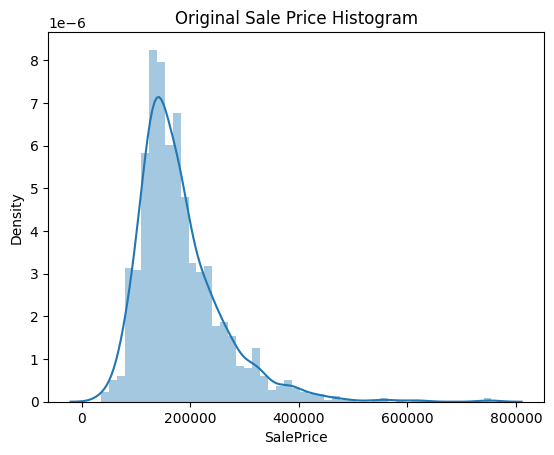

In [42]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

<Axes: title={'center': 'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

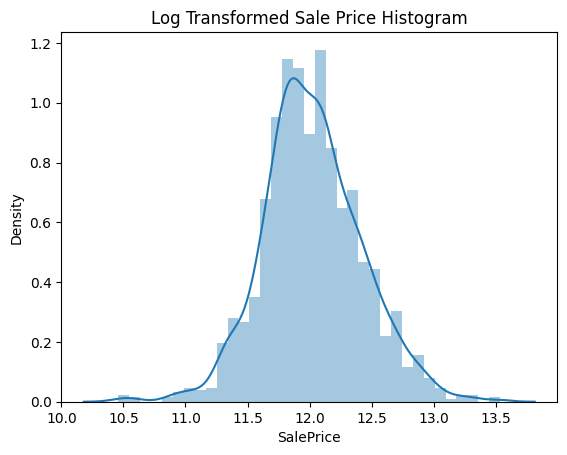

In [43]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [44]:
#SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

#Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id','PoolQC', 'MiscFeature','Alley','Fence','FireplaceQu'], axis=1,inplace=True)

#드롭하지 않은 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(numeric_only=True), inplace=True)

#Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## NUll 피처의 Type: \n', house_df.dtypes[null_column_count.index])

## NUll 피처의 Type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [45]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_coulmn_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type:\n', house_df_ohe.dtypes[null_coulmn_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 270)
## Null 피처의 Type:
 Series([], dtype: object)


선형 회귀 모델 학습/예측/평가

In [46]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test,pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
  return rmse

def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [47]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

#LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.127
Lasso 로그 변환된 RMSE: 0.176


[0.13183184688250854, 0.1274058283626615, 0.17628250556471403]

In [48]:
def get_top_bottom_coef(model, n=10):
  #coef_ 속성을 기반으로 Series 객체를 생성. index 칼럼명.
  coef = pd.Series(model.coef_, index=X_features.columns)

  #+상위 10개, -하위 10개의 회귀 계수를 추출해 반환
  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

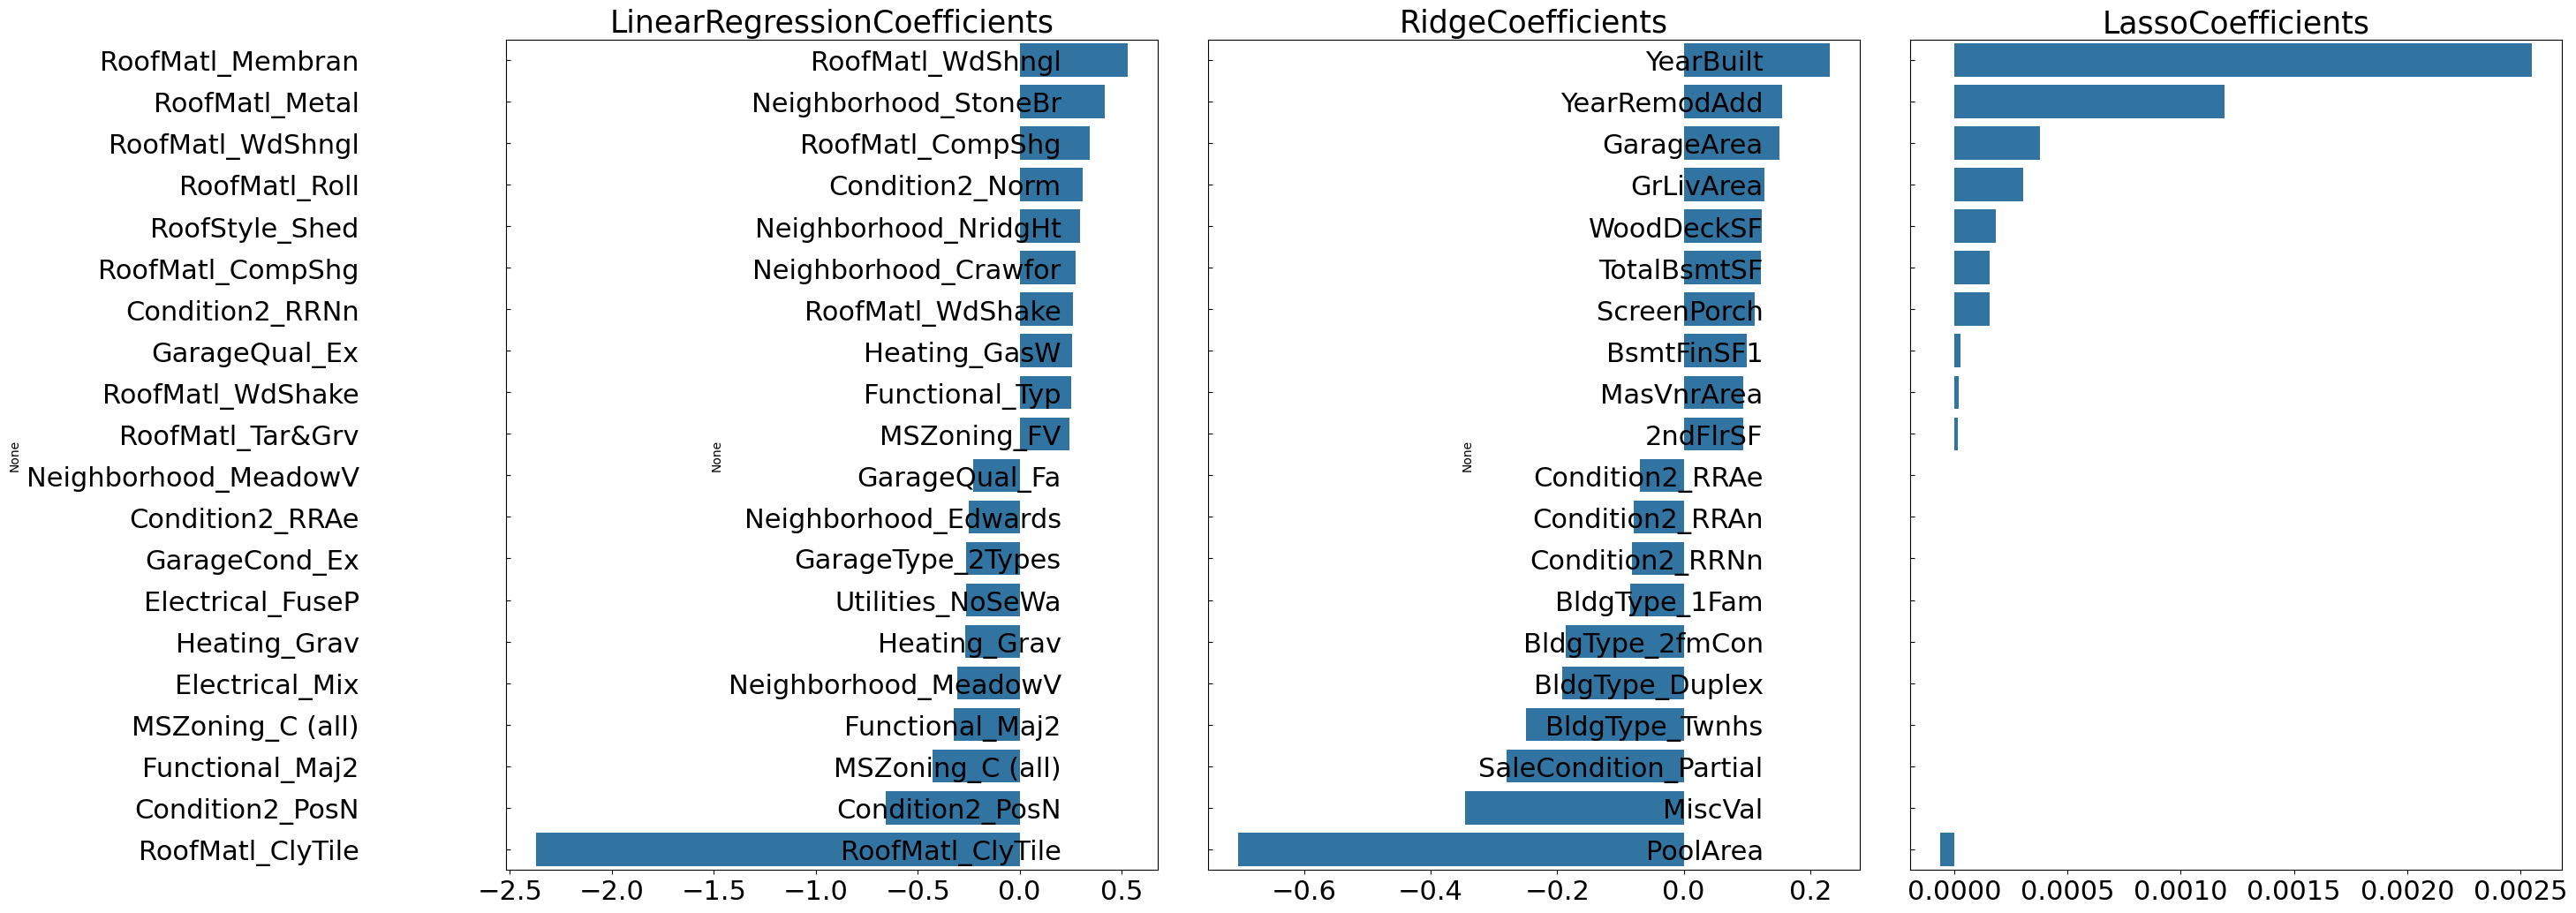

In [49]:
def visualize_coefficient(models):
  #3개의 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
  fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
  fig.tight_layout()
  #입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화.
  for i_num, model in enumerate(models):
    #상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])
    #ax subplot에 barchart로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
    axs[i_num].set_title(model.__class__.__name__+'Coefficients', size=25)
    axs[i_num].tick_params(axis='y', direction='in', pad=120)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

#앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [50]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
  for model in models:
    #분할하지 않고 전체 데이터로 cross_val_score() 수행, 모델별 CV RMSE 값과 평균 RMSE 출력
    rmse_list = np.sqrt(-cross_val_score(model, X_features,y_target,scoring='neg_mean_squared_error', cv=5))

    rmse_avg = np.mean(rmse_list)
    print('\n{0} CV RNSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
    print('\n{0} CV 평균 RMSE 값 : {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

#앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RNSE 값 리스트: [0.135 0.165 0.167 0.111 0.198]

LinearRegression CV 평균 RMSE 값 : 0.155

Ridge CV RNSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]

Ridge CV 평균 RMSE 값 : 0.144

Lasso CV RNSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]

Lasso CV 평균 RMSE 값 : 0.198


In [51]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid=params,scoring='neg_mean_squared_error',cv=5)
  grid_model.fit(X_features,y_target)
  rmse = np.sqrt(-1*grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값 : {1}, 최적 alpha: {2}'.format(model.__class__.__name__, np.round(rmse,4), grid_model.best_params_))

ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1418, 최적 alpha: {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.142, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


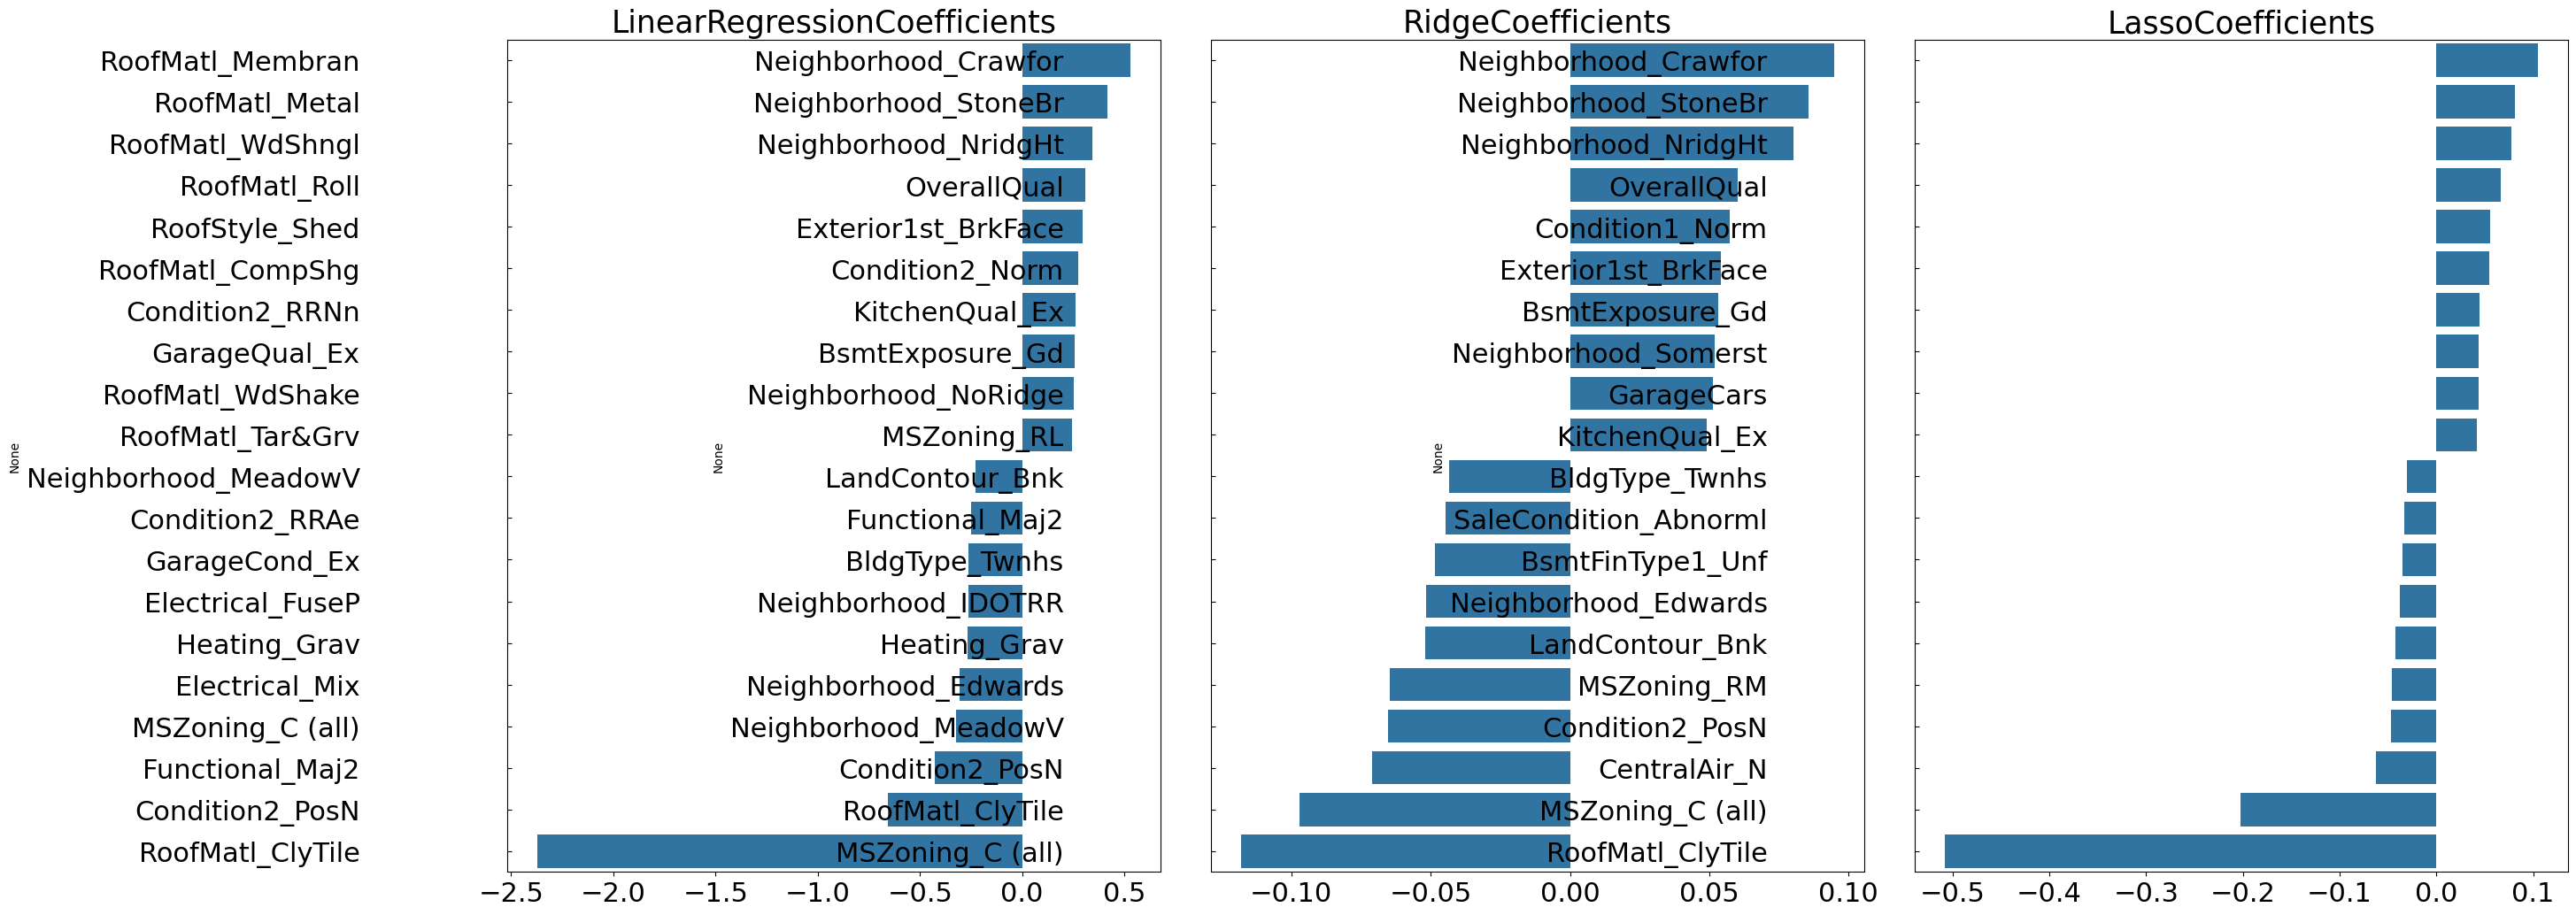

In [52]:
#앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

#모든 모델의 회귀 게수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [53]:
from scipy.stats import skew

#object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
#hosue_df에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = house_df[features_index].apply(lambda x: skew(x))
#skew(왜곡) 정도가 1 이상인 칼럼만 추출..
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [54]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [55]:
#왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state = 156)

#피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha' : [.005,0.1,1,5,8,10,12,15,20]}
lasso_params = { 'alpha' : [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1275, 최적 alpha: {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1252, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


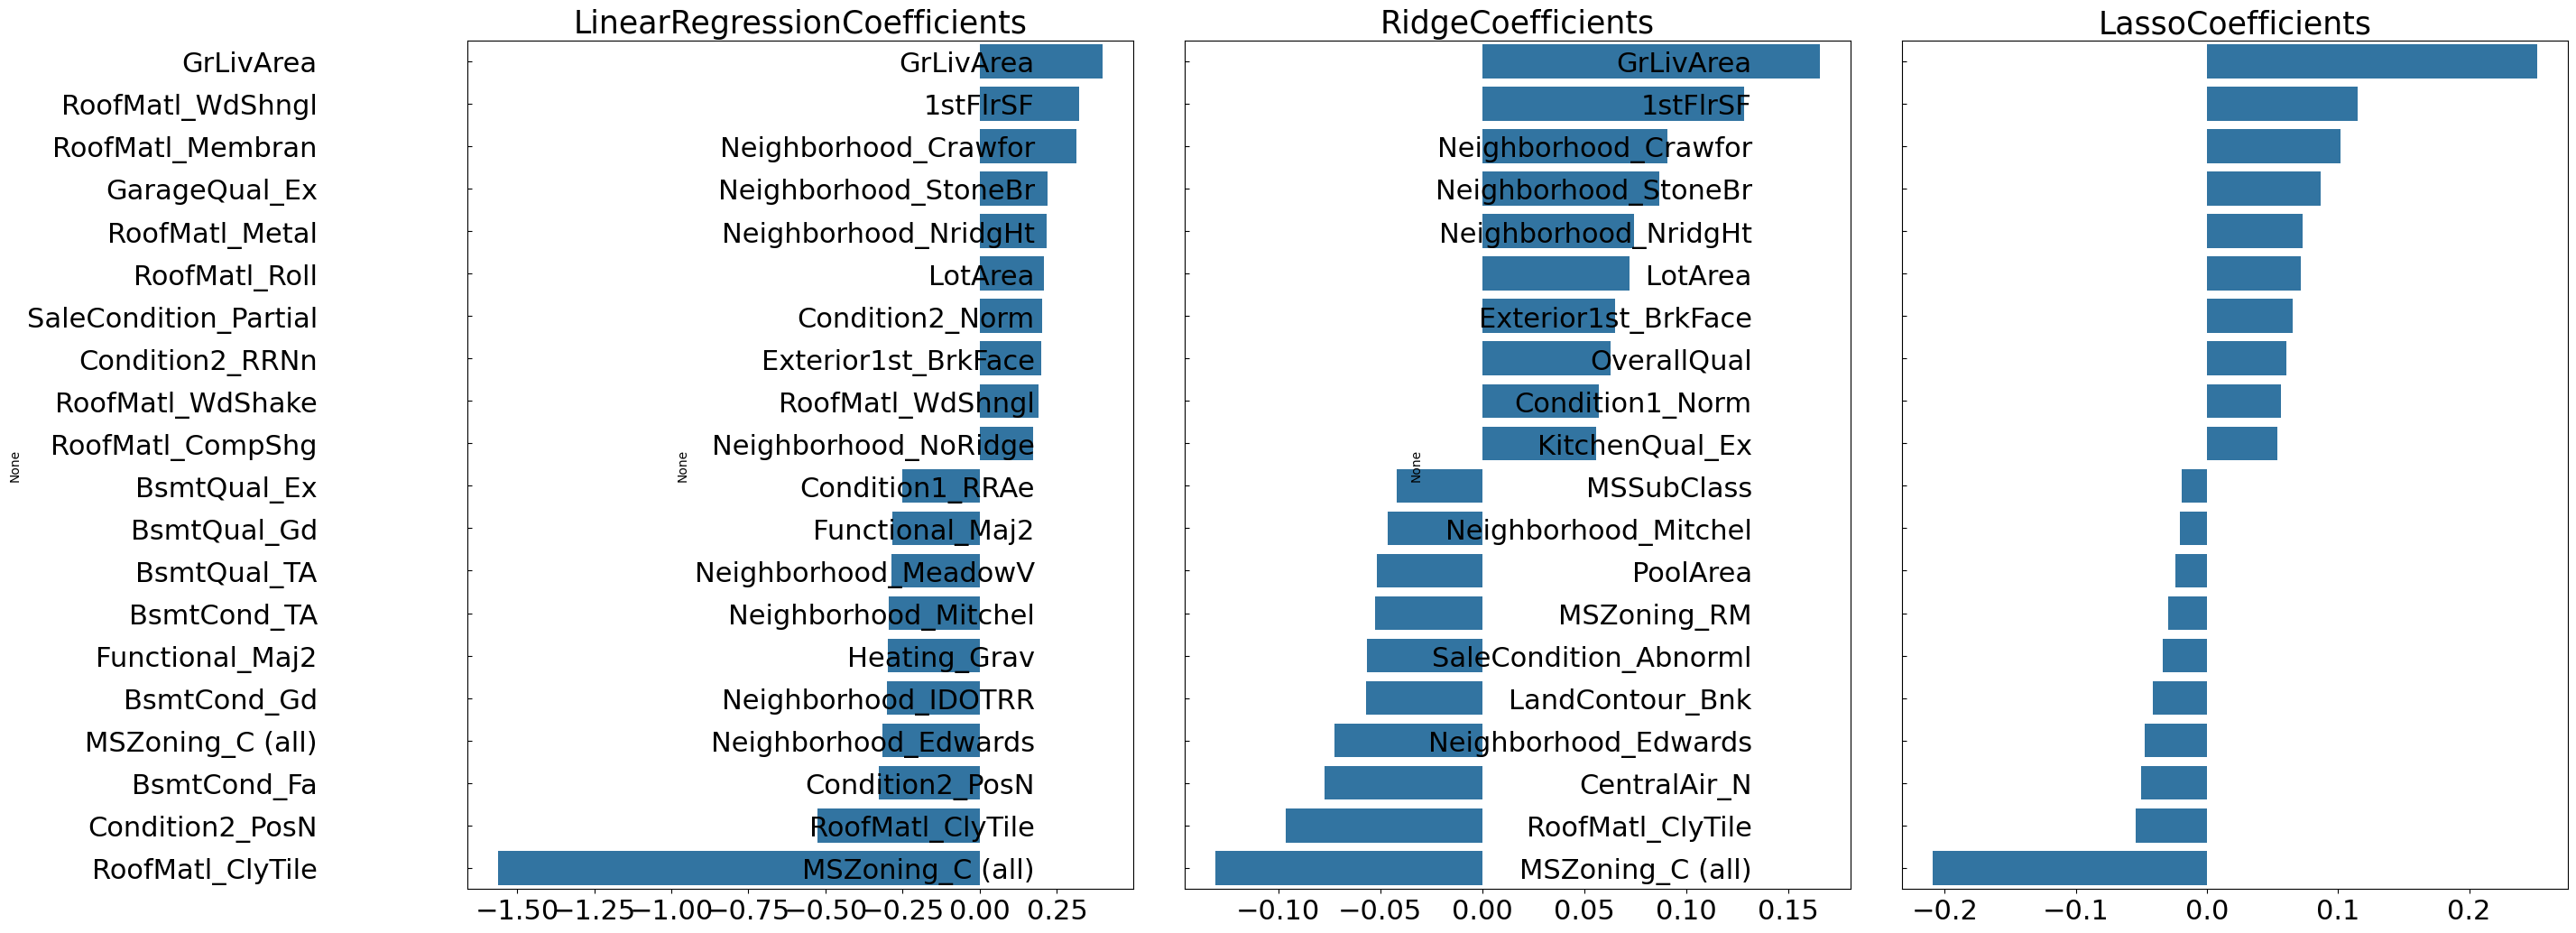

In [56]:
#앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

#모든 모델의 회귀 게수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

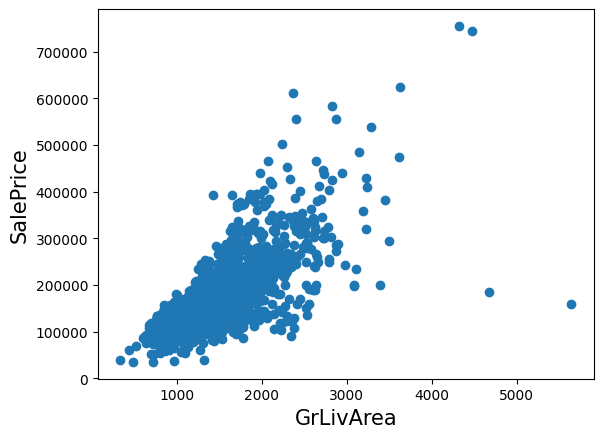

In [57]:
plt.scatter(x = house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [58]:
#GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성.
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1&cond2].index

print('이상치 레코드 index: ', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape: ', house_df_ohe.shape)

#DataFrame의 인덱스를 이용해 이상치 레코드 삭제.
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape: ', house_df_ohe.shape)

이상치 레코드 index:  [ 523 1298]
이상치 삭제 전 house_df_ohe shape:  (1460, 270)
이상치 삭제 후 house_df_ohe shape:  (1458, 270)


In [59]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test,y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1125, 최적 alpha: {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1122, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


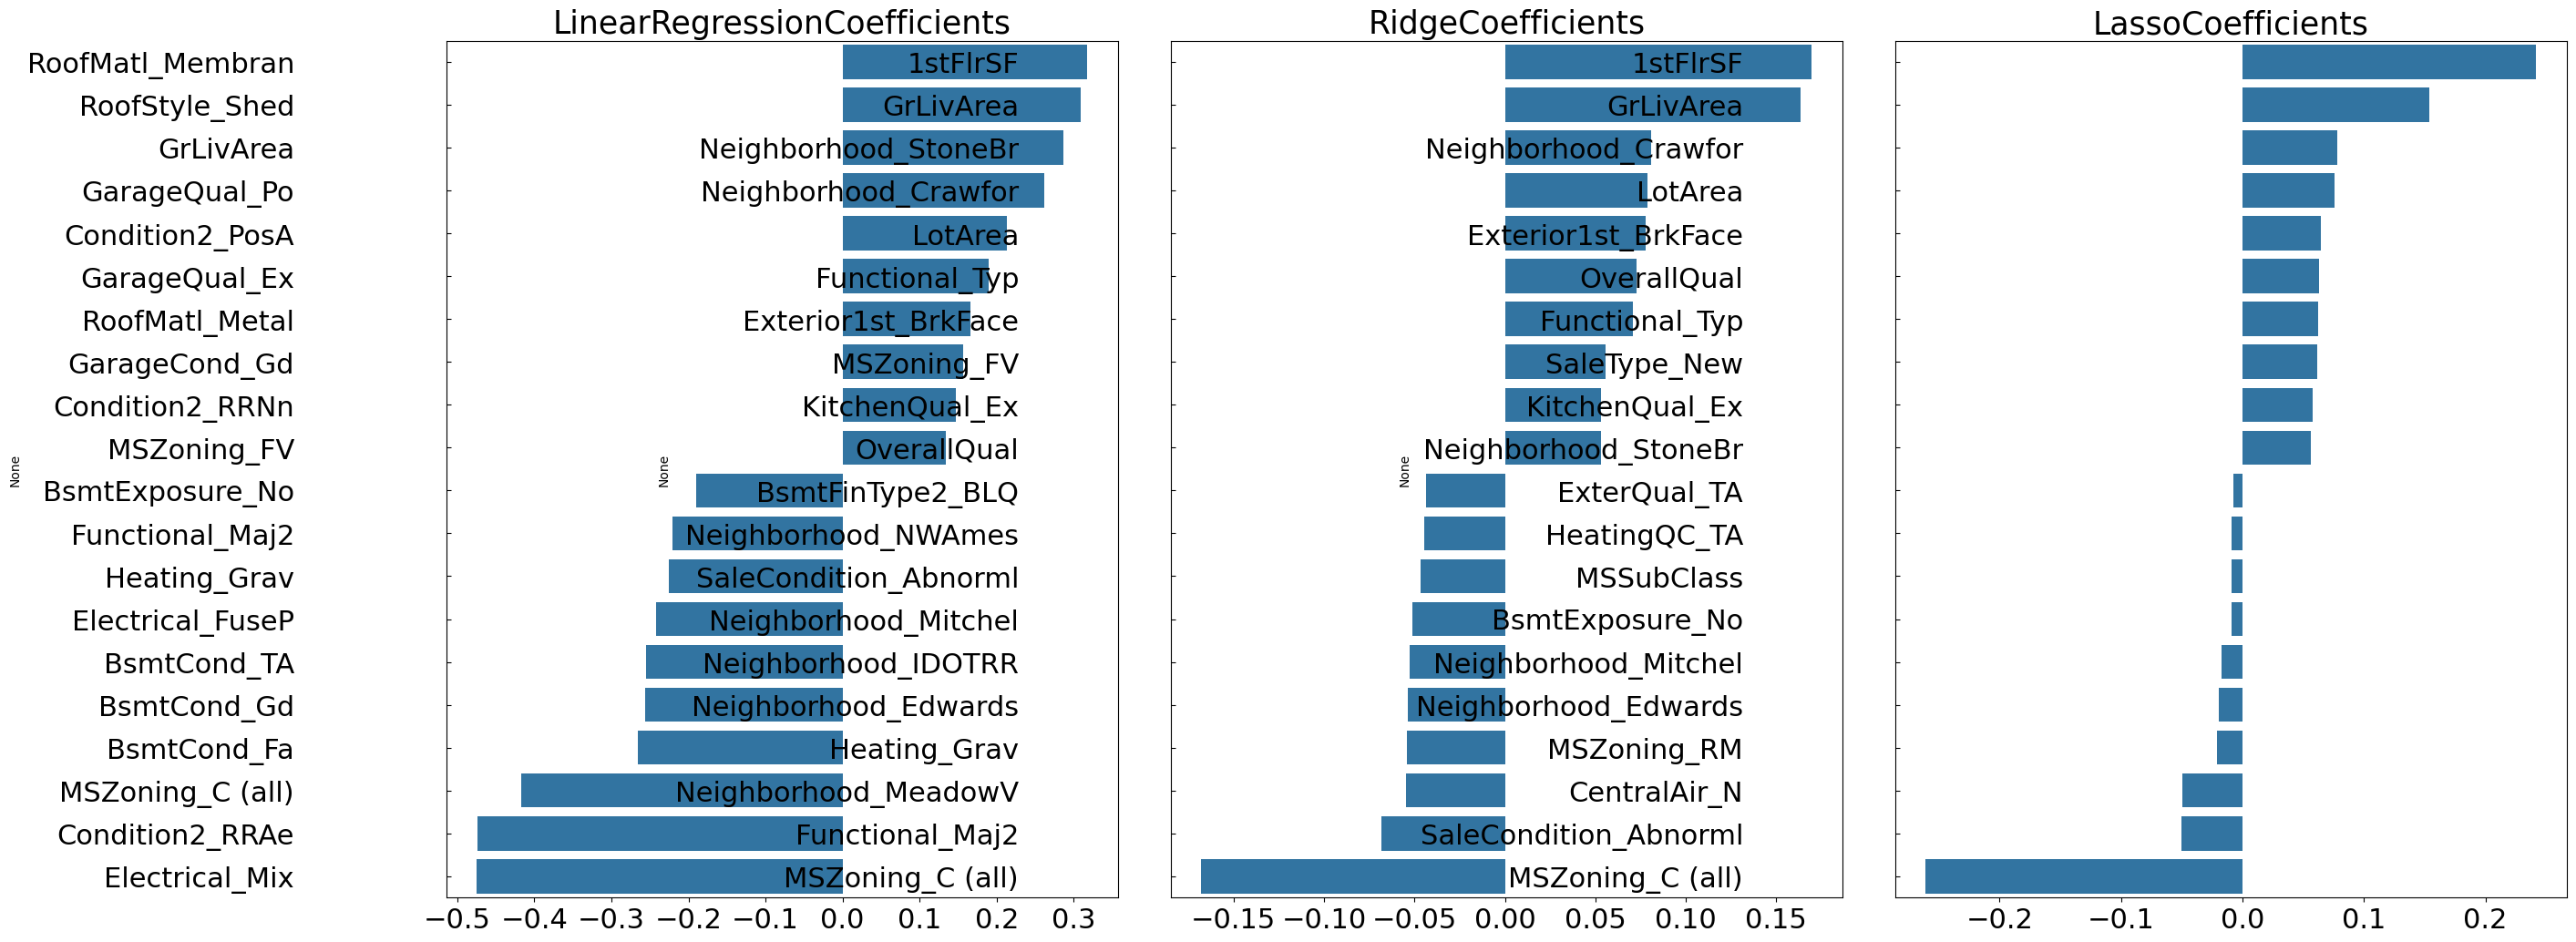

In [60]:
#앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

#모든 모델의 회귀 게수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

회귀 트리 모델 학습/예측/평가

In [61]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators' : [1000]}
xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, colsample_bytree = 0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1185, 최적 alpha: {'n_estimators': 1000}


In [62]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators': [1000]}
lgbm_reg = LGBMRegressor(n_estimators = 1000, learning_rate = 0.05, num_leaves = 4, subsample=0.6, colsample_bytree = 0.4, reg_lambda = 10, n_jobs = -1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 171
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 168
[LightGBM] [Info] Start training from score 12.023516
[LightGBM] [Warning] Found

회귀 모델의 예측 결과 혼합을 통한 최종 예측

In [63]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE : {1}'.format(key, rmse))

#개별 모델의 학습
ridge_reg = Ridge(alpha = 8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

#개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4*ridge_pred + 0.6*ridge_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso' : lasso_pred}

#최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.10340697165289348
Ridge 모델의 RMSE : 0.10340697165289348
Lasso 모델의 RMSE : 0.10024171179335342


In [64]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves = 4, subsample=0.6, colsample_by_tree=0.4, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5*xgb_pred + 0.5*lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM' : xgb_pred,
         'LGBM' : lgbm_pred}

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.025343
[LightGBM] [Warning] Unknown parameter: colsample_by_tree


스태킹 앙상블 모델을 통한 회귀 예측

In [65]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  #지정된 n_folds 값으로 KFold 생성
  kf = KFold(n_splits = n_folds, shuffle = False)
  #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__,'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트:', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
    model.fit(X_tr, y_tr)
    #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    #입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장.
    test_pred[:, folder_counter] = model.predict(X_test_n)

  #폴듣 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis =1).reshape(-1,1)

  #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

In [66]:
#get_stacking_base_datasets() 는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

#각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, n_folds=5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, n_folds=5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, n_folds=5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, n_folds=5)

Ridge model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
Lasso model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
XGBRegressor model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
LGBMRegressor model 시작
	 폴드 세트: 0 시작
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 156
[LightGBM] [Info] Start training from score 12.035561
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
	 폴드 세트: 1 시작
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tr

In [67]:
#개별 모델이 반환한 학습 및 테스트용  데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train,lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test,lasso_test, xgb_test, lgbm_test), axis=1)

#최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha = 0.0005)

#개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.097668982508778


### 4. 군집화 실습 - 고객 세그먼테이션

- 고객 세그먼테이션의 정의와 기법

다양한 기준으로 고객을 분류하는 기법

CRM이나 마케팅의 중요 기반 요소

주요 목표 : 타깃 마케팅 - 고객을 여러 특성에 맞게 세분화해서 그 유형에 따라 맞춤형 마케팅이나 서비스를 제공하는 것

RFM 기법 이용: RECENCY - 가장 최근 상품 구입 일에서 오늘까지의 기간, FREQUENCY - 상품 구매 횟수, MONETARY VALUE - 총 구매 금액

- 데이터 세트 로딩과 데이터 클렌징

In [69]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io='Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [70]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [71]:
retail_df=retail_df[retail_df['Quantity']>0]
retail_df=retail_df[retail_df['UnitPrice']>0]
retail_df=retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [72]:
retail_df['Country'].value_counts()[:5]

,count
Country,
United Kingdom,354321
Germany,9040
France,8341
EIRE,7236
Spain,2484


- RFM 기반 데이터 가공

사전 정제된 데이터 기반으로 고객 세그먼테이션 군집화를 RFM 기반으로 수행

이를 위해 필요한 데이터 가공

In [73]:
retail_df['sale_amount']=retail_df['Quantity']*retail_df['UnitPrice']
retail_df['CustomerID']=retail_df['CustomerID'].astype(int)

In [74]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

CustomerID
17841    7847
14911    5675
14096    5111
12748    4595
14606    2700
Name: count, dtype: int64
CustomerID
14646    280206.02
18102    259657.30
17450    194550.79
16446    168472.50
14911    143825.06
Name: sale_amount, dtype: float64


In [75]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.0258946320786095

In [76]:
#DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
#Recency: InvoiceDate 칼럼의 max()에서 가공
#Frequency: InvoiceNo 칼럼의 count()
#Monetary: sale_amount 칼럼의 sum()
aggregations={
    'InvoiceDate' : 'max',
    'InvoiceNo' : 'count',
    'sale_amount' : 'sum'
}
cust_df=retail_df.groupby('CustomerID').agg(aggregations)

# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df=cust_df.rename(columns={'InvoiceDate' : 'Recency',
                                'InvoiceNo' : 'Frequency',
                                'sale_amount' : 'Monetary'
                               })
cust_df=cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12347,2011-12-07 15:52:00,182,4310.00
2,12348,2011-09-25 13:13:00,31,1797.24


In [77]:
import datetime as dt

cust_df['Recency']=dt.datetime(2011, 12, 10)-cust_df['Recency']
cust_df['Recency']=cust_df['Recency'].apply(lambda x : x.days+1)
print('cust_df 로우와 칼럼 건수는', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는 (4338, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,3,182,4310.00
2,12348,76,31,1797.24


- RFM 기반 고객 세그먼테이션

왜곡된 데이터 분포도에서 군집화를 수행할 때 어떤 현상이 발생하는지 알아봄

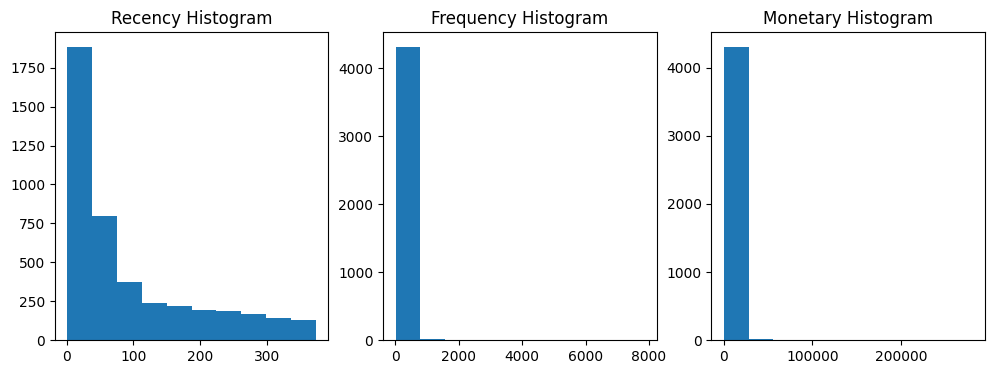

In [78]:
fig, (ax1, ax2, ax3)=plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

plt.show()

In [79]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,93.059474,91.720609,2054.266460
std,100.012264,228.785094,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,307.415000
50%,51.000000,41.000000,674.485000
75%,142.750000,100.000000,1661.740000
max,374.000000,7847.000000,280206.020000


In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features=cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled=StandardScaler().fit_transform(X_features)

kmeans=KMeans(n_clusters=3, random_state=0)
labels=kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label']=labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.602


In [81]:
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    #입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    #plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    #리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        #KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        #클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [82]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np

    #plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    #입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

     #리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        #KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        #클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

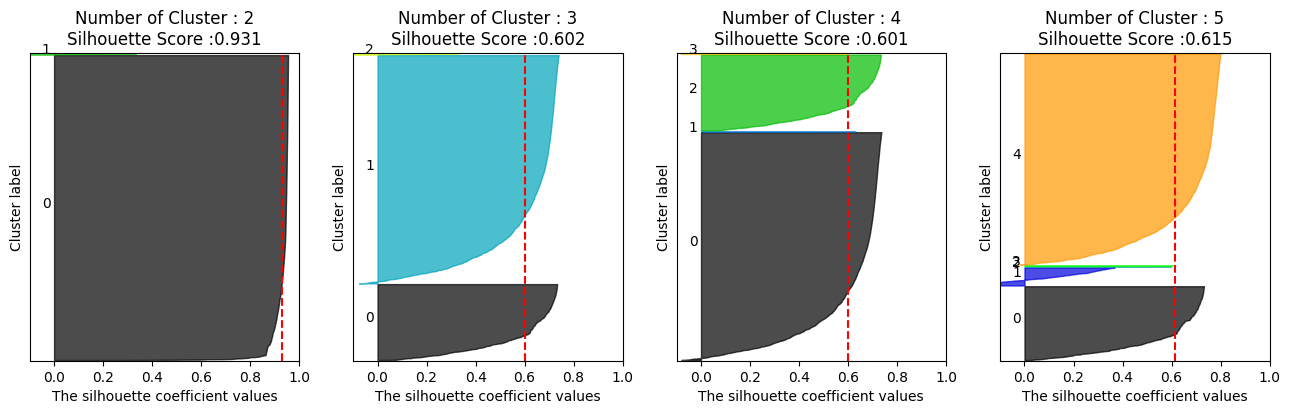

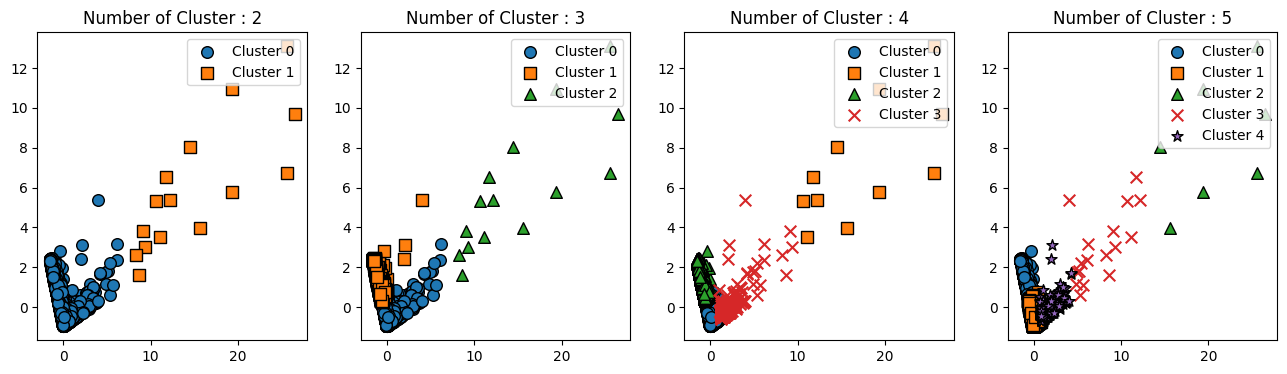

In [83]:
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df['Recency_log']=np.log1p(cust_df['Recency'])
cust_df['Frequency_log']=np.log1p(cust_df['Frequency'])
cust_df['Monetary_log']=np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features=cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled=StandardScaler().fit_transform(X_features)
kmeans=KMeans(n_clusters=3, random_state=0)
labels=kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label']=labels
print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.304
